# Mimetic Finite Difference Method for Fluid Simulation
## Using the node-edge discretization

First we will define a procedure for convenience to initialize our grid parameters:

In [1]:
module MFDGridMod

    immutable type MFDGrid
        xs::Array{Float64}
        extxs::Array{Float64}
        dx::Float64
        n::Int64 # number of nodes in one dimension 
        ne::Int64 # number of horizontal (or vertical) edges
    end

    # Initialize grid parameters
    function init_grid(dx) 
        xs = [-1.0:dx:1.0]; # an array of nodal positions along one axis (same for both axes);
        extxs = [xs, 1.0+dx];
        # Count the degrees of freedom on our grid
        n = length(xs); # number of nodes on each axis
        ne = n*(n+1); # number of horizontal (or vertical) edges

        MFDGrid(xs, extxs, dx, n, ne)
    end

    export MFDGrid, init_grid;
end;

In [2]:
import MFDGridMod: MFDGrid, init_grid;

Next we can define procedures to sample continuous functions on our discrete grid mesh:

In [227]:
# Helper function used to sample a vector based function on a grid
function sample_vecfield(g::MFDGrid, vec_field)
    apply_with_off(f, A, off, k) = (i,j) -> A[i,j] = f(g.extxs[i]+off[1], g.extxs[j]+off[2])[k]; # for vector functions

     # Define a mac-like grid
    uv = Array(Float64, (g.n,g.n+1)); # vertical velocity matrix
    cartesianmap(apply_with_off(vec_field, uv, [0,-g.dx*0.5], 2), size(uv));

    uh = Array(Float64, (g.n+1,g.n)); # horizontal velocity matrix
    cartesianmap(apply_with_off(vec_field, uh, [-g.dx*0.5,0], 1), size(uh));
    
    [uh[:], uv[:]]
end

function sample_scalarfield(g::MFDGrid, scalar_field)
    apply(f, A) = (i,j) -> A[i,j] = f(g.xs[i], g.xs[j]); # for scalar functions

    mtx = Array(Float64, (g.n,g.n)); # nodal pressure matrix
    cartesianmap(apply(scalar_field, mtx), size(mtx));
    mtx[:]
end

# Define a function to sample given pressure, input and output velocity test functions given some grid size
function init(g::MFDGrid, pres, in_vel, out_vel)
    # assemble system vectors
    p = sample_scalarfield(g, pres);
    u = sample_vecfield(g, in_vel);
    u_sol = sample_vecfield(g, out_vel);

    p, u, u_sol
end

function get_interior_edges(g::MFDGrid) 
    fst_row_horiz = [2:g.n];
    add_horiz = [0:g.n+1:(g.n+1)*(g.n-1)];
    fst_row_vert = g.ne+g.n+[1:g.n];
    add_vert = [0:g.n:g.n*(g.n-2)];
    vec(fst_row_horiz .+ add_horiz'), vec(fst_row_vert .+ add_vert')
end

# Converts a computed edge based velocity field into a plottable velocity field
function interpolate_vel(g::MFDGrid, u)
    indices = get_interior_edges(g);
    uh = reshape(u[indices[1]], (g.n-1, g.n));
    uv = reshape(u[indices[2]], (g.n, g.n-1));
    U = 0.5*(uh[:,1:end-1] + uh[:,2:end]);
    V = 0.5*(uv[1:end-1,:] + uv[2:end,:]);
    U', V'
end;

The following procedures draw the corresponding magnitude and vector fields:

In [228]:
using Color
using Gadfly
import PyPlot

function plot_nodes(g::MFDGrid, p)
    xmin = repeat(g.xs-g.dx*0.5, outer=[g.n]);
    xmax = repeat(g.xs+g.dx*0.5, outer=[g.n]);
    ymin = repeat(g.xs-g.dx*0.5, inner=[g.n]);
    ymax = repeat(g.xs+g.dx*0.5, inner=[g.n]);
    plot(x_min=xmin, x_max=xmax, y_min=ymin, y_max=ymax, color=p,
          Scale.y_continuous(minvalue=-1, maxvalue=1),
          Scale.x_continuous(minvalue=-1, maxvalue=1),
          Guide.xlabel("x"), Guide.ylabel("y"),
          Coord.cartesian(aspect_ratio=1.0),
          Geom.rectbin, Scale.ContinuousColorScale(c -> RGB(0,c,0)))
end

function plot_hedges(g::MFDGrid, u)
    xmin = repeat([g.extxs]-g.dx, outer=[g.n]);
    xmax = repeat([g.extxs], outer=[g.n]);
    ymin = repeat(g.xs-g.dx*0.5, inner=[g.n+1]);
    ymax = repeat(g.xs+g.dx*0.5, inner=[g.n+1]);
    plot(x_min=xmin, x_max=xmax, y_min=ymin, y_max=ymax, color=u[1:g.ne],
          Scale.y_continuous(minvalue=-1, maxvalue=1),
          Scale.x_continuous(minvalue=-1, maxvalue=1),
          Guide.xlabel("x"), Guide.ylabel("y"),
          Coord.cartesian(aspect_ratio=1.0),
          Geom.rectbin, Scale.ContinuousColorScale(c -> RGB(c,0,0)))
end

function plot_vedges(g::MFDGrid, u)
    xmin = repeat(g.xs-g.dx*0.5, outer=[g.n+1]);
    xmax = repeat(g.xs+g.dx*0.5, outer=[g.n+1]);
    ymin = repeat([g.extxs] - g.dx, inner=[g.n]);
    ymax = repeat([g.extxs], inner=[g.n]);
    plot(x_min=xmin, x_max=xmax, y_min=ymin, y_max=ymax, color=u[g.ne+1:end],
          Scale.y_continuous(minvalue=-1, maxvalue=1),
          Scale.x_continuous(minvalue=-1, maxvalue=1),
          Guide.xlabel("x"), Guide.ylabel("y"),
          Coord.cartesian(aspect_ratio=1.0),
          Geom.rectbin, Scale.ContinuousColorScale(c -> RGB(0,c,c)))
end

# to plot a vector field, use the following interface:
function plot_vecfield(g::MFDGrid, u)
    # Define a function construct a matrix of values used for plotting
    meshgrid(v::AbstractVector) = meshgrid(v, v)
    function meshgrid{T}(vx::AbstractVector{T}, vy::AbstractVector{T})
        m, n = length(vy), length(vx)
        vx = reshape(vx, 1, n)
        vy = reshape(vy, m, 1)
        (repmat(vx, m, 1), repmat(vy, 1, n))
    end

    X,Y = meshgrid(g.xs[1:end-1] + 0.5*g.dx, g.xs[1:end-1] + 0.5*g.dx);
    U,V = interpolate_vel(g, u);
    PyPlot.quiver(X, Y, U, V)
end

# test vector field drawing
function test_vecfield_plot()
    dx = 0.1; # side length of one grid cell
    g = init_grid(dx);
    u = sample_vecfield(g, (x,y) -> [y,-x]);
    plot_vecfield(g, u)
end

#test_vecfield_plot();

In [229]:
# Assemble the Gradient as applied to p (column-wise flattened pressure matrix)
# block giving a column of m-1 horizontal velocities from a column of m pressures
function assemble_G(g::MFDGrid)
    V = fill(1.0/g.dx, g.n);
    V[1] = 1.0/(g.dx*g.dx);
    Gx = spdiagm((-reverse(V),V), (-1,0));
    Gxs = kron(speye(g.n), Gx);

    # block giving a row of m-1 vertical velocities from a row of m pressures
    Gys = kron(Gx, speye(g.n));

    # At this point we decide how our edges will be ordered in the matrix equations.
    # We choose the horizontal edges uhin[:] followed by vertical edges uvin[:]
    # return the full gradient operator:
    G = [Gxs; Gys]
end;

In [230]:
function get_bdry_edges(g::MFDGrid)
    bottom = [1:g.n+1];
    top = bottom + g.ne - g.n - 1;
    left = g.ne + bottom*g.n - g.n + 1;
    right = left + g.n - 1;
    [left, bottom, right, top]
end
function get_normal_bdry_edges(g::MFDGrid) 
    bottom = g.ne + [1:g.n];
    top = bottom + g.ne - g.n - 2;
    left = [1:g.n]*(g.n+1) - g.n;
    right = left + g.n;
    [left, bottom, right, top]
end
# Assemble the matrices R and N, and use them to compute M.
function assemble_M(g::MFDGrid)
    # Indeed we know that the local matrix M is defined by 0.5*dx*dx*eye(4)
    # the boundary edges will get one contribution from a local matrix and the
    # internal edges will get 2, hence we will treat these separately.
    # first collect the boundary indices:
    bdry = get_normal_bdry_edges(g);
    V = fill(g.dx*g.dx, 2*g.ne);
    V[bdry] = 0.5*g.dx*g.dx;
    spdiagm(V, 0)
end;

Next we construct a procedure to enforce Dirichlet boundary conditions by explicitly injecting the known pressure values at the boundary nodes of the grid mesh.

In [231]:
# define a function to pin down a pressure values at the given nodes of the mesh
function pin_pressure!(A, rhs, p, nodes)
    rhs[:] -= sum(A[:,nodes]*p[nodes],2);
    rhs[nodes] = p[nodes]; # explicitly set the rhs as solved 
    l = length(rhs);
    A[:,nodes] = 0;
    A[nodes,:] = 0;
    A[(l+1)*nodes - l] = 1; # set the diagonal elements to 1
end

# a helper function to collect all boundary node indices
function get_bdry_nodes(g)
    bottom = [1:g.n];
    top = bottom + g.ne;
    left = bottom[2:g.n-1]*g.n - g.n + 1;
    right = left + g.n - 1;
    [bottom, left, right, top]
end

# define a function to force Dirichlet boundary conditions
function force_dirichlet!(g, A, rhs, p)
    pin_pressure!(A, rhs, p, get_bdry_nodes(g));
end;

In [232]:
# pressure solution
pressure3(x, y) = -cos(0.5*pi*x)*cos(0.5*pi*y);

# final velocity solution
a = sqrt(2)*pi/3;
up(x,y) = cos(a*(x + y) + pi/2);
um(x,y) = cos(a*(x - y) - pi/2);
output_velocity3(x, y) = [um(x,y) + up(x,y), um(x,y) - up(x,y)]/sqrt(2);

# initial conditions
grad_p(x,y) = [ 0.5*pi*sin(0.5*pi*x)*cos(0.5*pi*y), 0.5*pi*sin(0.5*pi*y)*cos(0.5*pi*x) ];
input_velocity3(x, y) = output_velocity3(x,y) + grad_p(x,y);

In [233]:
dx = 1.0; # side length of one grid cell
g = init_grid(dx);
p, u, u_sol = init(g, pressure3, input_velocity3, output_velocity3);

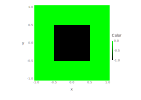

In [234]:
plot_nodes(g, p)

In [240]:
G = assemble_G(g);
M = assemble_M(g);
#println(g.ne)
D = -G'*M;
println(full(D'));
println(full(G));
#println(size(D));
#println(size(full(A)));
A = D*G; # rebuild this since we modified it after enforcing boundary conditions
println(full(A));
b = D*u;
println(b);
#assert(norm(u_sol - u + G*p) <= 0.5*g.dx); #verify that the gradient operator is correct;
#pin_pressure!(A, b, p, [div(g.n*g.n, 2)]);
pnew = A\b;
println("Using matrix M: $(norm(p-pnew, Inf))");
unew = u - G*pnew;

[-0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 1.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 1.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 -0.5 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 1.0 -1.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 1.0 -1.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.5 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 -0.5 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 1.0 -1.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 -1.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.5
 -0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 -0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 -0.5 0.0 0.0 0.0 0.0 0.0 0.0
 1.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.0 0.0
 0.0 1.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.0
 0.0 0.0 1.0 0.0 0.0 -1.0 0.0 0.0 0.0
 0.0 0.0 0.0 1.0 0.0 0.0 -1.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.5 0.0 0.0 -0.5 0.0
 0.0 0.0 0.0 0.0 0.0 0.5 0.0 0.0 -0.5
 0.0 0.0 0.0 0.0 0.0 0.0 0.5 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
[1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 -1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 -1.0 1.0 0.0 

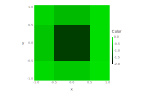

In [236]:
plot_nodes(g, pnew)

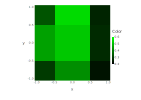

In [237]:
plot_nodes(g, abs(p-pnew))

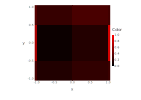

In [238]:
plot_hedges(g, abs(u_sol-unew))

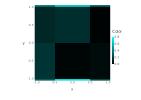

In [239]:
plot_vedges(g, abs(u_sol-unew))

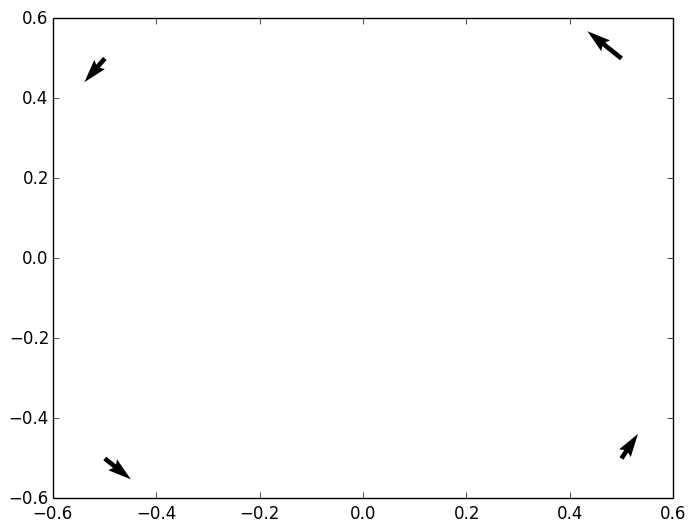

In [214]:
plot_vecfield(g, u - G*pnew);

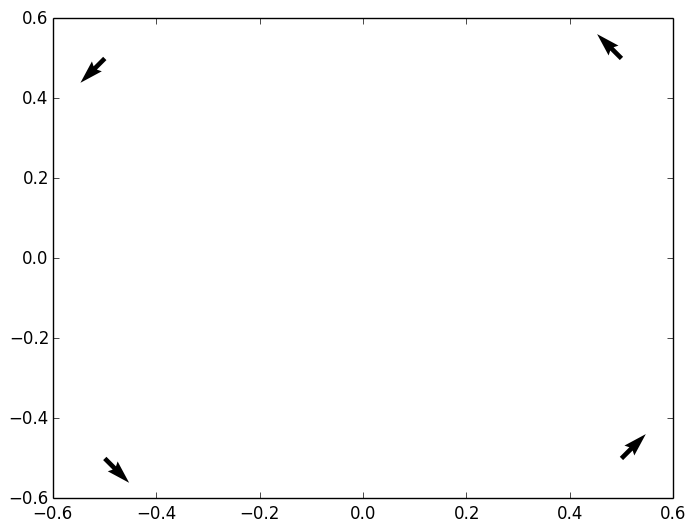

In [213]:
plot_vecfield(g, u_sol);

## Convergence in both examples
We will now look at the convergence of the projection method with respect to grid size.

In [74]:
# Define priniting routines
function printheader()
    @printf(" grid  , P inf-norm , order , v inf-norm , order , P two-norm , order , v two-norm , order , P one-norm , order , v one-norm , order \n");
end

function printdata!(g::MFDGrid, pdiff, udiff, prev)
    pmax = norm(pdiff, Inf);
    p2 = 0.5*g.dx*norm(pdiff, 2);
    p1 = 0.25*g.dx*g.dx*norm(pdiff, 1);    
    umax = norm(udiff, Inf);
    u2 = 0.5*g.dx*norm(udiff, 2);
    u1 = 0.25*g.dx*g.dx*norm(udiff, 1);
    data = [pmax, umax, p2, u2, p1, u1];

    order = zeros(6);
    if ( prev != zeros(6) )
        order = log2(prev./data);
    end
    
    @printf("%4d^2 , %8.4e , %5.2f , %8.4e , %5.2f", g.n-1, data[1], order[1], data[2], order[2]);
    @printf(" , %8.4e , %5.2f , %8.4e , %5.2f", data[3], order[3], data[4], order[4]);
    @printf(" , %8.4e , %5.2f , %8.4e , %5.2f \n", data[5], order[5], data[6], order[6]);
    prev[:] = data;
end;

In [77]:
# Convenience routine to assemble system given a pressure, input velocity and output velocity functions
function assemble(dx, pres, v_in, v_out)
    # Assemble the linear system using the edge based mass matrix M
    g = init_grid(dx);
    p, u_in, u_sol = init(g, pres, v_in, v_out);
    G = assemble_G(g);
    M = assemble_M(g);
    D = G'*M;
    A = D*G;
    b = D*u_in;
    A, b, G, p, u_in, u_sol, g
end
# Convenience method to solve a given system and output the error from the ground truth
function solve(A, b, G, p, u_in, u_sol)
    pnew = A\b;
    unew = u_in - G*pnew;
    pdiff = p - pnew;
    udiff = u_sol - unew;
    pdiff, udiff
end;

In [79]:
is3 = [1:10];
dxs = 2./2.^is3;
printheader();
prev = zeros(6); # a previous set of data
data3 = Array(Float64,(length(is3),6));
for i in is3
    dx = dxs[i];
    A, b, G, p, u_in, u_sol, g = assemble(dx, pressure3, input_velocity3, output_velocity3);
    #assert(norm(u_sol - u_in + G*p) <= 0.5*dx);
    #pin_pressure!(GtMG, rhs, p, [div(g.n*g.n, 2)]);
    #force_dirichlet!(GtMG, rhs, p, n);
    pdiff, udiff = solve(A, b, G, p, u_in, u_sol);
    printdata!(g, pdiff, udiff, prev);
    data3[i,1:6] = prev;
end

 grid  , P inf-norm , order , v inf-norm , order , P two-norm , order , v two-norm , order , P one-norm , order , v one-norm , order 
   2^2 , 5.4296e-01 ,  0.00 , 8.4524e-01 ,  0.00 , 5.7575e-01 ,  0.00 , 8.4186e-01 ,  0.00 , 8.2657e-01 ,  0.00 , 1.6179e+00 ,  0.00 
   4^2 , 2.8234e-01 ,  0.94 , 3.6362e-01 ,  1.22 , 2.7976e-01 ,  1.04 , 3.6803e-01 ,  1.19 , 3.3217e-01 ,  1.32 , 5.6554e-01 ,  1.52 
   8^2 , 9.3090e-02 ,  1.60 , 1.4712e-01 ,  1.31 , 8.1152e-02 ,  1.79 , 8.9594e-02 ,  2.04 , 8.7304e-02 ,  1.93 , 1.0975e-01 ,  2.37 
  16^2 , 2.4333e-02 ,  1.94 , 5.2195e-02 ,  1.50 , 2.0065e-02 ,  2.02 , 1.9689e-02 ,  2.19 , 2.0640e-02 ,  2.08 , 2.0564e-02 ,  2.42 
  32^2 , 6.1259e-03 ,  1.99 , 6.6483e-02 , -0.35 , 4.9278e-03 ,  2.03 , 1.3609e-02 ,  0.53 , 4.9523e-03 ,  2.06 , 8.4964e-03 ,  1.28 
  64^2 , 1.5356e-03 ,  2.00 , 9.3741e-02 , -0.50 , 1.2190e-03 ,  2.02 , 1.4977e-02 , -0.14 , 1.2101e-03 ,  2.03 , 4.4151e-03 ,  0.94 
 128^2 , 3.8424e-04 ,  2.00 , 1.0934e-01 , -0.22 , 3.0305e-04 

In [157]:
# Define plotting routines
function plot_results(xdata,ydata,ylabel)
    logydata = log2(ydata);
    a,b = linreg(xdata, logydata);
    pl = plot(x=xdata, y=logydata, Guide.XLabel("Grid Size"), Guide.YLabel("Log( $ylabel )"), Geom.point);
    append!(pl.layers, layer(x=xdata, y=[a+b*i for i in xdata], Geom.line));
    println("slope = $b");
    println("R = $(cor(xdata,logydata))");
    pl
end;

slope = -0.20515723729958177
R = -0.5290797023659295


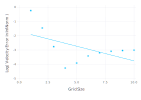

In [158]:
plot_results([1.0:size(data3, 1)], data3[:,2], "Velocity Error in Inf-Norm")

slope = -0.7440926098410898
R = -0.9053885234671841


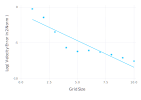

In [159]:
plot_results([1.0:size(data3, 1)], data3[:,4], "Velocity Error in 2-Norm")

slope = -1.3559206430642432
R = -0.9805602625167114


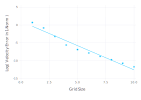

In [160]:
plot_results([1.0:size(data3, 1)], data3[:,6], "Velocity Error in 1-Norm")